<a href="https://colab.research.google.com/github/mkhalil7625/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Copy_of_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
import pandas as pd
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install eli5

In [2]:
# df = pd.read_csv('vehicles.csv')
# df.head()
# ! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

In [3]:
# !unzip bank-additional.zip

In [4]:
# bank=pd.read_csv('bank-additional/bank-additional-full.csv',sep=';')
# bank2=pd.read_csv('bank-additional/bank-additional.csv',sep=';')

In [5]:
# df = pd.concat([bank,bank2],axis=0).reset_index()

In [6]:
# Baseline Majority class
# df['y'].value_counts(normalize=True)

In [7]:
# df.head()

In [8]:
# import category_encoders as ce
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from scipy.stats import randint, uniform
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [9]:
# target = 'y'
# features = df.columns.drop(target)
# X_train = df[features]
# y_train = df[target]

In [10]:
# pipline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True),
#     # SimpleImputer(),
#     # StandardScaler(),
#     RandomForestClassifier(random_state=42)
# )
# param_distributions = {
#     'randomforestclassifier__n_estimators': randint(50, 300), 
#     'randomforestclassifier__max_depth': [40, None], 
#     'randomforestclassifier__max_features': randint(1, 9),
#     'randomforestclassifier__criterion': ["gini", "entropy"],
#     'randomforestclassifier__min_samples_leaf':[1,2]
# }

# search = RandomizedSearchCV(
#     pipline,
#     param_distributions=param_distributions,
#     return_train_score=True,
#     cv=5,
#     n_iter=3,
#     scoring = 'roc_auc',
#     verbose = 10,
#     random_state=42,
#     n_jobs=-1,
# )
# search.fit(X_train,y_train)

In [11]:
# print('Best hyperparameters', search.best_params_)
# print('Cross-validation ROC', search.best_score_)

In [12]:
# search.get_params()

In [13]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [15]:
# split train into train abnd val
train,val = train_test_split(train, test_size=.20, stratify=train['status_group'],random_state=42)
train.shape,val.shape,test.shape

((47520, 41), (11880, 41), (14358, 40))

In [16]:
#baseline; majority class
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [17]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [18]:
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [19]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=42, n_jobs=-1, 
                           min_samples_leaf=3, 
                           n_estimators=200)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on validation
print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Train Accuracy 0.9096170033670034
Validation Accuracy 0.8124579124579124


In [20]:
# eli5 does not work with model in the pipeline

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(random_state=42, n_jobs=-1, 
                           min_samples_leaf=3, 
                           n_estimators=200)
model.fit(X_train_transformed,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
import eli5

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
# import eli5
from eli5.sklearn import PermutationImportance

In [23]:
permuter = PermutationImportance(
    model,scoring='accuracy',n_iter=5,random_state=42
)
permuter.fit(X_val_transformed,y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=3,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [24]:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.1047 ± 0.0045,quantity
0.0123 ± 0.0022,waterpoint_type
0.0113 ± 0.0026,longitude
0.0111 ± 0.0018,extraction_type_class
0.0110 ± 0.0013,amount_tsh
0.0097 ± 0.0031,latitude
0.0065 ± 0.0009,population
0.0063 ± 0.0016,payment
0.0063 ± 0.0019,waterpoint_type_group
0.0062 ± 0.0011,construction_year


In [25]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (47520, 45)


In [26]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [27]:
print('Shape after removing features:', X_train.shape)

Shape after removing features: (47520, 40)


In [32]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=42, n_jobs=-1, 
                           min_samples_leaf=3, 
                           n_estimators=200)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
# print('Validation Accuracy', pipeline.score(X_val, y_val))
print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.9066919191919192
Validation Accuracy 0.813973063973064


In [33]:
print('Shape before removing features:', X_train.shape)
print('Shape before removing features:', X_val.shape)

Shape before removing features: (47520, 40)
Shape before removing features: (11880, 40)


In [43]:
# XGBOOST
from xgboost import XGBClassifier
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depend on early stopping
    max_depth=70,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.5, # try higher learning rate
    n_jobs=-1
)
eval_set = [(X_train_encoded,y_train),
            (X_val_encoded,y_val)]

model.fit(X_train_encoded,y_train,
          eval_set = eval_set,
          eval_metric = 'merror',
          early_stopping_rounds=50
          )

[0]	validation_0-merror:0.068035	validation_1-merror:0.220875
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.041393	validation_1-merror:0.210774
[2]	validation_0-merror:0.026221	validation_1-merror:0.207071
[3]	validation_0-merror:0.016498	validation_1-merror:0.207071
[4]	validation_0-merror:0.009954	validation_1-merror:0.206145
[5]	validation_0-merror:0.005724	validation_1-merror:0.204545
[6]	validation_0-merror:0.003451	validation_1-merror:0.203704
[7]	validation_0-merror:0.002083	validation_1-merror:0.203956
[8]	validation_0-merror:0.001263	validation_1-merror:0.202862
[9]	validation_0-merror:0.000652	validation_1-merror:0.202694
[10]	validation_0-merror:0.000442	validation_1-merror:0.203704
[11]	validation_0-merror:0.000337	validation_1-merror:0.202946
[12]	validation_0-merror:0.000295	validation_1-merror:0.202609
[13]	validation_0-merror:0.0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=70,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [35]:
model.best_score

0.199916

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning:

Attempting to set identical bottom == top == 0.5 results in singular transformations; automatically expanding.



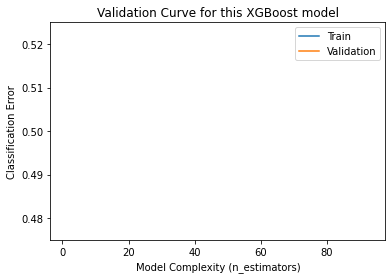

In [44]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
plt.ylim((0.5, 0.5)) # Zoom in
plt.legend();